LetsGrowMore - Internship

## Emotion Detector using Machine Learning and Song Recommender

This project is divided into two parts :-

Creating an image classifier using AlexNet architecture by using the given data.
Using the trained model to output a song based on the emotions of the image.

In [46]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from mtcnn import MTCNN  # helps in detecting faces from image
from keras.utils.vis_utils import plot_model
import warnings

In [47]:
train_dir = "./train/" #passing the path with training images
test_dir = "./test/" #passing the path with test images

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       happy   sad  fear  surprise  neutral  angry  disgust
train   7215  4830  4097      3171     4965   3995      436
      happy   sad  fear  surprise  neutral  angry  disgust
test   1774  1247  1024       831     1233    958      111


### Plot of number of images in training set

Text(0, 0.5, 'Count')

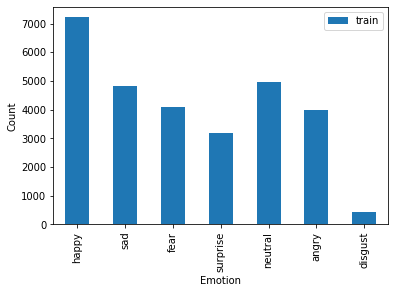

In [48]:
train_count.transpose().plot(kind='bar')
plt.xlabel("Emotion")
plt.ylabel("Count")

There seem to be less images tagged as disgust and most of them are are happy images.

### Plot of number of images in test set

Text(0, 0.5, 'Count')

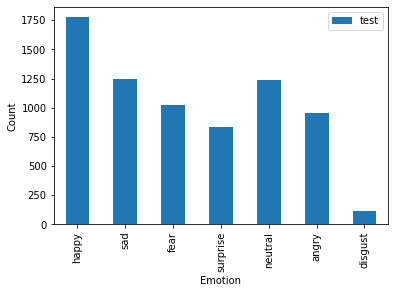

In [49]:
test_count.transpose().plot(kind='bar')
plt.xlabel("Emotion")
plt.ylabel("Count")

The test set have a similar distributions as the training set.

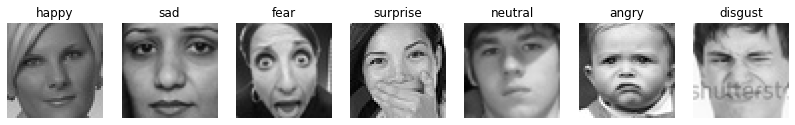

In [50]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

### Creating Training and test sets

In [51]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [52]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [53]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [54]:
epochs = 20
batch_size = 64

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 128)      

### Training the model

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Epoch 1/20
  7/449 [..............................] - ETA: 15:25 - loss: 9.6711 - accuracy: 0.1805

KeyboardInterrupt: 

### Plot Accuracy and Loss

NameError: name 'history' is not defined

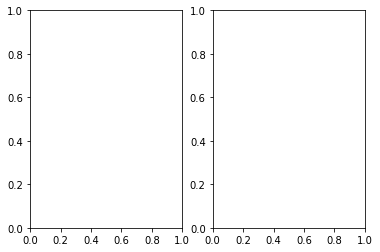

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Save model

In [ ]:
model.save('model_mood_detecction_song_recommendation.h5')

In [ ]:
train_loss, train_acc = model.evaluate(training_set)
test_loss, test_acc   = model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

## Testing

/var/folders/6c/zltlp5xs2kl551dv8jgmxmdh0000gn/T/ipykernel_5647/502840720.py:3: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  image = plt.imread(img)
/var/folders/6c/zltlp5xs2kl551dv8jgmxmdh0000gn/T/ipykernel_5647/502840720.py:5: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  image = plt.imread(img, format='jpg')


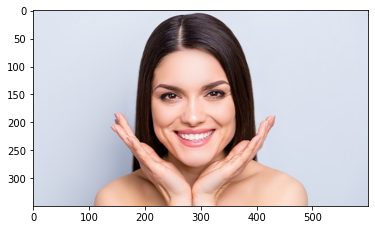

In [ ]:
img = 'https://static-bebeautiful-in.unileverservices.com/Unlock-flawless-skin_MobileHomeFeature.jpg'
try:
    image = plt.imread(img)
except SyntaxError:
    image = plt.imread(img, format='jpg')
plt.imshow(image)

#### Detecting face

In [ ]:
detect = MTCNN()
results = detect.detect_faces(image)

x1, y1, width, height = results[0]['box']
x2, y2 = x1 + width, y1 + height

face = image[y1:y2, x1:x2]
plt.imshow(face)

NameError: name 'MTCNN' is not defined

#### Resizing Image

In [ ]:
test_image = np.resize(face, (224,224,1))

## Prediction

In [ ]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

test_img = np.expand_dims(test_image, axis = 0)
test_img = test_img.reshape(-1,224,224,1)
result = model.predict(test_img)
result = list(result[0])

img_index = result.index(max(result))
emotion = label_dict[img_index]
print(emotion)

#### Save weights

In [ ]:
model.save_weights('model_weights.h5')

### Song Recommendation

In [ ]:
from IPython.display import Audio
song_path = './songs/'
song = os.path.join(song_path,emotion)
print(f'Playing {emotion} song')
Audio(song + '.mp3', autoplay=True)